# Projeto Airbnb Rio - Ferramenta de Previsão de Preço de Imóvel para pessoas comuns 

### Contexto

No Airbnb, qualquer pessoa que tenha um quarto ou um imóvel de qualquer tipo (apartamento, casa, chalé, pousada, etc.) pode ofertar o seu imóvel para ser alugado por diária.

Você cria o seu perfil de host (pessoa que disponibiliza um imóvel para aluguel por diária) e cria o anúncio do seu imóvel.

Nesse anúncio, o host deve descrever as características do imóvel da forma mais completa possível, de forma a ajudar os locadores/viajantes a escolherem o melhor imóvel para eles (e de forma a tornar o seu anúncio mais atrativo)

Existem dezenas de personalizações possíveis no seu anúncio, desde quantidade mínima de diária, preço, quantidade de quartos, até regras de cancelamento, taxa extra para hóspedes extras, exigência de verificação de identidade do locador, etc.

### Objetivo

Construir um modelo de previsão de preço que permita uma pessoa comum que possui um imóvel possa saber quanto deve cobrar pela diária do seu imóvel.

Ou ainda, para o locador comum, dado o imóvel que ele está buscando, ajudar a saber se aquele imóvel está com preço atrativo (abaixo da média para imóveis com as mesmas características) ou não.

### O que temos disponível, inspirações e créditos

As bases de dados foram retiradas do site kaggle: https://www.kaggle.com/allanbruno/airbnb-rio-de-janeiro

- As bases de dados são os preços dos imóveis obtidos e suas respectivas características em cada mês.
- Os preços são dados em reais (R$)
- Temos bases de abril de 2018 a maio de 2020, com exceção de junho de 2018 que não possui base de dados

### Expectativas Iniciais

- Acredito que a sazonalidade pode ser um fator importante, visto que meses como dezembro costumam ser bem caros no RJ
- A localização do imóvel deve fazer muita diferença no preço, já que no Rio de Janeiro a localização pode mudar completamente as características do lugar (segurança, beleza natural, pontos turísticos)
- Adicionais/Comodidades podem ter um impacto significativo, visto que temos muitos prédios e casas antigos no Rio de Janeiro

Vamos descobrir o quanto esses fatores impactam e se temos outros fatores não tão intuitivos que são extremamente importantes.

### Importar Bibliotecas e Bases de Dados

In [51]:
import pathlib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split

In [ ]:
meses = {
    "jan": 1,
    "fev": 2,
    "mar": 3,
    "abr": 4,
    "mai": 5,
    "jun": 6,
    "jul": 7,
    "ago": 8,
    "set": 9,
    "out": 10,
    "nov": 11,
    "dez": 12,
}

caminho_bases = pathlib.Path("dataset")

base_airbnb = pd.DataFrame()

for arquivo in caminho_bases.iterdir():
    nome_mes = arquivo.name[:3]
    mes = meses[nome_mes]
    ano = arquivo.name[-8:]
    ano = int(ano[:4])
    df = pd.read_csv(caminho_bases / arquivo.name)
    df["mes"] = mes
    df["ano"] = ano
    base_airbnb = pd.concat([base_airbnb, df], ignore_index=True)

display(base_airbnb)

C:\Users\Fernando\AppData\Local\Temp\ipykernel_4296\2041524095.py:25: DtypeWarning: Columns (62,87) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(caminho_bases / arquivo.name)
C:\Users\Fernando\AppData\Local\Temp\ipykernel_4296\2041524095.py:25: DtypeWarning: Columns (61,62,94) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(caminho_bases / arquivo.name)
C:\Users\Fernando\AppData\Local\Temp\ipykernel_4296\2041524095.py:25: DtypeWarning: Columns (61,62,94) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(caminho_bases / arquivo.name)
C:\Users\Fernando\AppData\Local\Temp\ipykernel_4296\2041524095.py:25: DtypeWarning: Columns (87) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(caminho_bases / arquivo.name)
C:\Users\Fernando\AppData\Local\Temp\ipykernel_4296\2041524095.py:25: DtypeWarning: Columns (61,62,94) ha

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,number_of_reviews_ltm,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms
0,14063,https://www.airbnb.com/rooms/14063,20180414160018,2018-04-14,Living in a Postcard,"Besides the most iconic's view, our apartment ...",NaN,"Besides the most iconic's view, our apartment ...",none,Best and favorite neighborhood of Rio. Perfect...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,17878,https://www.airbnb.com/rooms/17878,20180414160018,2018-04-14,Very Nice 2Br - Copacabana - WiFi,Please note that special rates apply for New Y...,- large balcony which looks out on pedestrian ...,Please note that special rates apply for New Y...,none,This is the best spot in Rio. Everything happe...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,24480,https://www.airbnb.com/rooms/24480,20180414160018,2018-04-14,Nice and cozy near Ipanema Beach,My studio is located in the best of Ipanema. ...,The studio is located at Vinicius de Moraes St...,My studio is located in the best of Ipanema. ...,none,"The beach, the lagoon, Ipanema is a great loca...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,25026,https://www.airbnb.com/rooms/25026,20180414160018,2018-04-14,Beautiful Modern Decorated Studio in Copa,"Our apartment is a little gem, everyone loves ...",This newly renovated studio (last renovations ...,"Our apartment is a little gem, everyone loves ...",none,Copacabana is a lively neighborhood and the ap...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,31560,https://www.airbnb.com/rooms/31560,20180414160018,2018-04-14,NICE & COZY 1BDR - IPANEMA BEACH,This nice and clean 1 bedroom apartment is loc...,This nice and clean 1 bedroom apartment is loc...,This nice and clean 1 bedroom apartment is loc...,none,Die Nachbarschaft von Ipanema ist super lebend...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
902205,38844730,https://www.airbnb.com/rooms/38844730,20190923212307,2019-09-24,TRANSAMERICA BARRA DA TIJUCA R IV,"Em estilo contemporâneo, o Transamerica Prime ...",NaN,"Em estilo contemporâneo, o Transamerica Prime ...",none,NaN,...,1.0,1.0,1125.0,1125.0,1.0,1125.0,0.0,15.0,0.0,0.0
902206,38846408,https://www.airbnb.com/rooms/38846408,20190923212307,2019-09-24,Alugo para o Rock in Rio,"Confortável apartamento, 2 quartos , sendo 1 s...",O apartamento estará com mobília completa disp...,"Confortável apartamento, 2 quartos , sendo 1 s...",none,"Muito próximo ao Parque Olímpico, local do eve...",...,2.0,2.0,1125.0,1125.0,2.0,1125.0,0.0,1.0,0.0,0.0
902207,38846703,https://www.airbnb.com/rooms/38846703,20190923212307,2019-09-24,Apt COMPLETO em COPACABANA c/TOTAL SEGURANÇA,Apartamento quarto e sala COMPLETO para curtas...,Espaço ideal para até 5 pessoas. Cama de casal...,Apartamento quarto e sala COMPLETO para curtas...,none,NaN,...,3.0,3.0,1125.0,1125.0,3.0,1125.0,0.0,23.0,6.0,0.0
902208,38847050,https://www.airbnb.com/rooms/38847050,20190923212307,2019-09-24,Cobertura Cinematografica,Cobertura alto nivel,NaN,Cobertura alto nivel,none,NaN,...,1.0,1.0,1125.0,1125.0,1.0,1125.0,0.0,1.0,0.0,0.0


### Agora vamos começar os tratamentos

- Como temos muitas colunas, nosso modelo pode acabar ficando muito lento.
- Além disso, uma análise rápida permite ver que várias colunas não são necessárias para o nosso modelo de previsão, por isso, vamos excluir algumas colunas da nossa base
- Tipos de colunas que vamos excluir:
    1. IDs, Links e informações não relevantes para o modelo
    2. Colunas repetidas ou extremamente parecidas com outra (que dão a mesma informação para o modelo. Ex: Data x Ano/Mês
    3. Colunas preenchidas com texto livre -> Não rodaremos nenhuma análise de palavras ou algo do tipo
    4. Colunas em que todos ou quase todos os valores são iguais
    
- Para isso, vamos criar um arquivo em excel com os 1.000 primeiros registros e fazer uma análise qualitativa, olhando as colunas e identificando quais são desnecessárias

In [3]:
base_airbnb.head(1000).to_excel("base_airbnb.xlsx", index=False)

### Depois da análise qualitativa das colunas, levando em conta os critérios explicados acima, ficamos com as seguintes colunas:


In [ ]:
colunas = [
    "host_response_time",
    "host_response_rate",
    "host_is_superhost",
    "host_listings_count",
    "latitude",
    "longitude",
    "property_type",
    "room_type",
    "accommodates",
    "bathrooms",
    "bedrooms",
    "beds",
    "bed_type",
    "amenities",
    "price",
    "security_deposit",
    "cleaning_fee",
    "guests_included",
    "extra_people",
    "minimum_nights",
    "maximum_nights",
    "number_of_reviews",
    "review_scores_rating",
    "review_scores_accuracy",
    "review_scores_cleanliness",
    "review_scores_checkin",
    "review_scores_communication",
    "review_scores_location",
    "review_scores_value",
    "instant_bookable",
    "is_business_travel_ready",
    "cancellation_policy",
    "ano",
    "mes",
]

base_airbnb = base_airbnb.loc[:, colunas]
print(list(base_airbnb.columns))
display(base_airbnb)

['host_response_time', 'host_response_rate', 'host_is_superhost', 'host_listings_count', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'price', 'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights', 'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'instant_bookable', 'is_business_travel_ready', 'cancellation_policy', 'ano', 'mes']


,host_response_time,host_response_rate,host_is_superhost,host_listings_count,latitude,longitude,property_type,room_type,accommodates,bathrooms,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,is_business_travel_ready,cancellation_policy,ano,mes
0,NaN,NaN,f,1.0,-22.946854,-43.182737,Apartment,Entire home/apt,4,1.0,...,9.0,9.0,9.0,9.0,9.0,f,f,strict_14_with_grace_period,2018,4
1,within an hour,100%,t,2.0,-22.965919,-43.178962,Condominium,Entire home/apt,5,1.0,...,9.0,10.0,10.0,9.0,9.0,t,f,strict,2018,4
2,within an hour,100%,f,1.0,-22.985698,-43.201935,Apartment,Entire home/apt,2,1.0,...,10.0,10.0,10.0,10.0,9.0,f,f,strict,2018,4
3,within an hour,100%,f,3.0,-22.977117,-43.190454,Apartment,Entire home/apt,3,1.0,...,10.0,10.0,10.0,10.0,9.0,f,f,strict,2018,4
4,within an hour,100%,t,1.0,-22.983024,-43.214270,Apartment,Entire home/apt,3,1.0,...,10.0,10.0,10.0,10.0,9.0,t,f,strict,2018,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
902205,within an hour,93%,f,0.0,-23.003180,-43.342840,Apartment,Entire home/apt,4,1.0,...,NaN,NaN,NaN,NaN,NaN,f,f,flexible,2019,9
902206,NaN,NaN,f,0.0,-22.966640,-43.393450,Apartment,Entire home/apt,4,2.0,...,NaN,NaN,NaN,NaN,NaN,f,f,flexible,2019,9
902207,within a few hours,74%,f,32.0,-22.962080,-43.175520,Apartment,Entire home/apt,5,1.0,...,NaN,NaN,NaN,NaN,NaN,f,f,strict_14_with_grace_period,2019,9
902208,NaN,NaN,f,0.0,-23.003400,-43.341820,Apartment,Entire home/apt,4,1.0,...,NaN,NaN,NaN,NaN,NaN,f,f,strict_14_with_grace_period,2019,9


### Tratar Valores Faltando

- Visualizando os dados, percebemos que existe uma grande disparidade em dados faltantes. As colunas com mais de 300.000 valores NaN serão excluídas da análise
- Para as outras colunas, como temos muitos dados (mais de 900.000 linhas) vamos excluir as linhas que contém dados NaN

In [ ]:
colunas_para_remover = [
    coluna for coluna in base_airbnb if base_airbnb[coluna].isnull().sum() > 300000
]
base_airbnb.drop(columns=colunas_para_remover, inplace=True)

display(base_airbnb)

,host_is_superhost,host_listings_count,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,...,guests_included,extra_people,minimum_nights,maximum_nights,number_of_reviews,instant_bookable,is_business_travel_ready,cancellation_policy,ano,mes
0,f,1.0,-22.946854,-43.182737,Apartment,Entire home/apt,4,1.0,0.0,2.0,...,2,$34.00,60,365,38,f,f,strict_14_with_grace_period,2018,4
1,t,2.0,-22.965919,-43.178962,Condominium,Entire home/apt,5,1.0,2.0,2.0,...,2,$51.00,4,90,205,t,f,strict,2018,4
2,f,1.0,-22.985698,-43.201935,Apartment,Entire home/apt,2,1.0,1.0,1.0,...,2,$215.00,3,90,85,f,f,strict,2018,4
3,f,3.0,-22.977117,-43.190454,Apartment,Entire home/apt,3,1.0,1.0,2.0,...,2,$45.00,4,30,208,f,f,strict,2018,4
4,t,1.0,-22.983024,-43.214270,Apartment,Entire home/apt,3,1.0,1.0,2.0,...,2,$68.00,2,1125,200,t,f,strict,2018,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
902205,f,0.0,-23.003180,-43.342840,Apartment,Entire home/apt,4,1.0,0.0,2.0,...,2,$50.00,1,1125,0,f,f,flexible,2019,9
902206,f,0.0,-22.966640,-43.393450,Apartment,Entire home/apt,4,2.0,2.0,3.0,...,1,$0.00,2,1125,0,f,f,flexible,2019,9
902207,f,32.0,-22.962080,-43.175520,Apartment,Entire home/apt,5,1.0,1.0,2.0,...,3,$30.00,3,1125,0,f,f,strict_14_with_grace_period,2019,9
902208,f,0.0,-23.003400,-43.341820,Apartment,Entire home/apt,4,1.0,1.0,1.0,...,1,$0.00,1,1125,0,f,f,strict_14_with_grace_period,2019,9


- Agora vamos excluir as linhas vazias

In [ ]:
base_airbnb = base_airbnb.dropna()
print(base_airbnb.shape)
base_airbnb.isnull().sum()

(897709, 23)


host_is_superhost           0
host_listings_count         0
latitude                    0
longitude                   0
property_type               0
room_type                   0
accommodates                0
bathrooms                   0
bedrooms                    0
beds                        0
bed_type                    0
amenities                   0
price                       0
guests_included             0
extra_people                0
minimum_nights              0
maximum_nights              0
number_of_reviews           0
instant_bookable            0
is_business_travel_ready    0
cancellation_policy         0
ano                         0
mes                         0
dtype: int64

### Verificar Tipos de Dados em cada coluna

- Precisamos fazer isso porque às vezes o Python está lendo como texto alguma coluna que deveria ser um número, então precisamos corrigir

In [ ]:
print(base_airbnb.dtypes)
print("-" * 50)
print(base_airbnb.iloc[0])

host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                        object
guests_included               int64
extra_people                 object
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
ano                           int64
mes                           int64
dtype: object
--------------------------------------------------
host_is_superhost                                                           f
host_listings_count          

- Como preço e extra people estão sendo reconhecidos como objeto (ao invés de ser um float) temos que mudar o tipo de variável da coluna.

In [ ]:
base_airbnb["price"] = (
    base_airbnb["price"]
    .astype(str)
    .replace("[$,]", "", regex=True)
    .astype(np.float32, copy=False)
)

base_airbnb["extra_people"] = (
    base_airbnb["extra_people"]
    .replace("[$,]", "", regex=True)
    .astype(np.float32, copy=False)
)

print(base_airbnb.dtypes)

C:\Users\Fernando\AppData\Local\Temp\ipykernel_4296\2304645614.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_airbnb["price"] = (


host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                       float32
guests_included               int64
extra_people                float32
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
ano                           int64
mes                           int64
dtype: object


C:\Users\Fernando\AppData\Local\Temp\ipykernel_4296\2304645614.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_airbnb["extra_people"] = (


### Análise Exploratória e Tratar Outliers

- Vamos basicamente olhar feature por feature para:
    1. Ver a correlação entre as features e decidir se manteremos todas as features que temos.
    2. Excluir outliers (usaremos como regra, valores abaixo de Q1 - 1.5xAmplitude e valores acima de Q3 + 1.5x Amplitude). Amplitude = Q3 - Q1
    3. Confirmar se todas as features que temos fazem realmente sentido para o nosso modelo ou se alguma delas não vai nos ajudar e se devemos excluir
    
- Vamos começar pelas colunas de preço (resultado final que queremos) e de extra_people (também valor monetário). Esses são os valores numéricos contínuos.

- Depois vamos analisar as colunas de valores numéricos discretos (accomodates, bedrooms, guests_included, etc.)

- Por fim, vamos avaliar as colunas de texto e definir quais categorias fazem sentido mantermos ou não.

MAS CUIDADO: não saia excluindo direto outliers, pense exatamente no que você está fazendo. Se não tem um motivo claro para remover o outlier, talvez não seja necessário e pode ser prejudicial para a generalização. Então tem que ter uma balança ai. Claro que você sempre pode testar e ver qual dá o melhor resultado, mas fazer isso para todas as features vai dar muito trabalho.

Ex de análise: Se o objetivo é ajudar a precificar um imóvel que você está querendo disponibilizar, excluir outliers em host_listings_count pode fazer sentido. Agora, se você é uma empresa com uma série de propriedades e quer comparar com outras empresas do tipo também e se posicionar dessa forma, talvez excluir quem tem acima de 6 propriedades tire isso do seu modelo. Pense sempre no seu objetivo

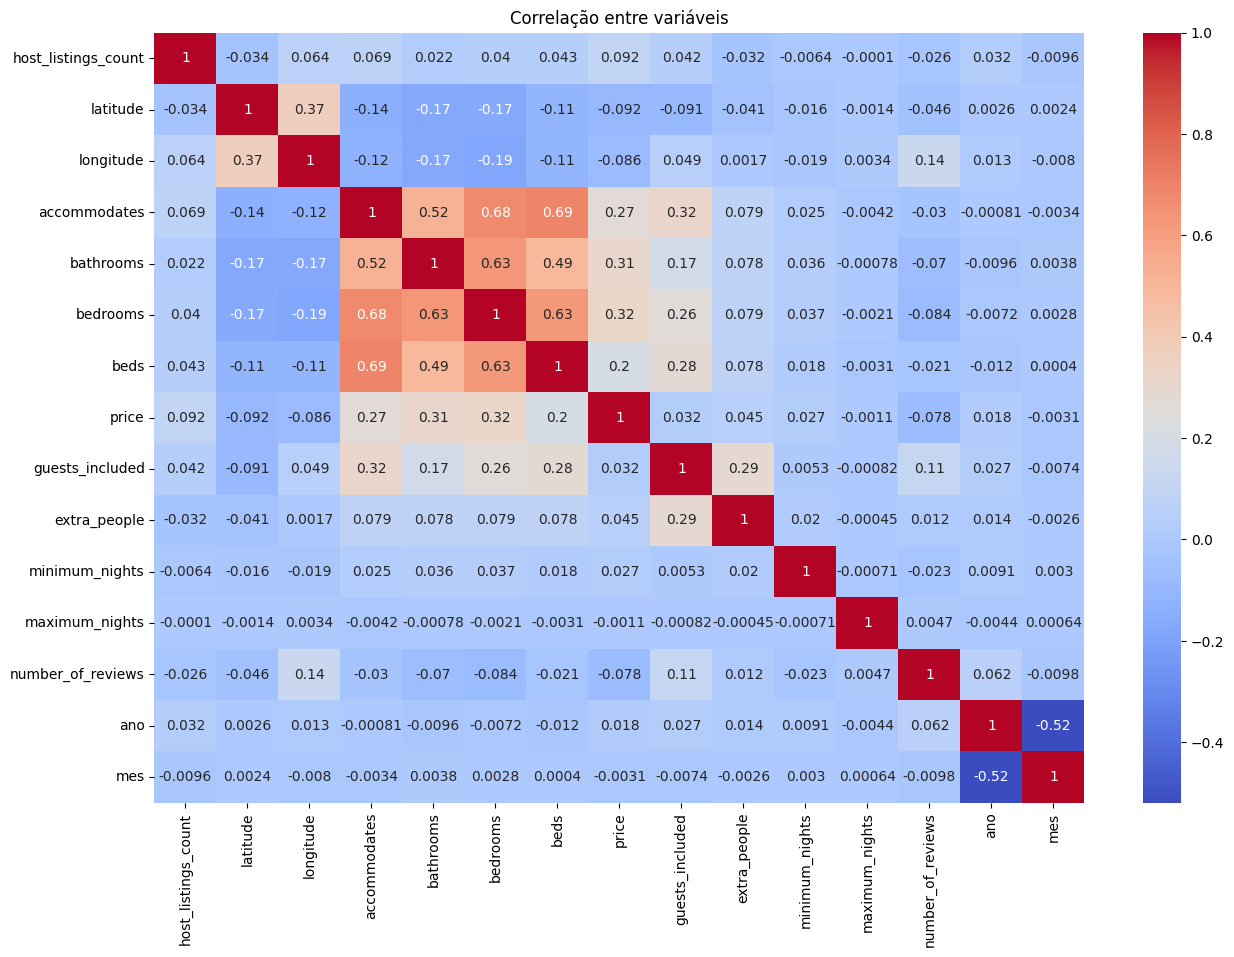

In [9]:
plt.figure(figsize=(15, 10))
sns.heatmap(base_airbnb.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlação entre variáveis")
plt.show()

### Definição de Funções para Análise de Outliers

Vamos definir algumas funções para ajudar na análise de outliers das colunas

In [ ]:
def limites(coluna):
    q1 = coluna.quantile(0.25)
    q3 = coluna.quantile(0.75)
    amplitude = q3 - q1
    limite_inferior = q1 - 1.5 * amplitude
    limite_superior = q3 + 1.5 * amplitude
    return limite_inferior, limite_superior

def excluir_outliers(df, nome_coluna):
    qtde_linhas = df.shape[0]
    lim_inf, lim_sup = limites(df[nome_coluna])
    df = df.loc[(df[nome_coluna] >= lim_inf) & (df[nome_coluna] <= lim_sup), :]
    linhas_removidas = qtde_linhas - df.shape[0]
    return df, linhas_removidas


limites(base_airbnb["price"])

(np.float64(-524.0), np.float64(1276.0))

In [ ]:
def diagrama_caixa(coluna):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    sns.boxplot(x=coluna, ax=ax1)
    ax2.set_xlim(limites(coluna))
    sns.boxplot(x=coluna, ax=ax2)

def histograma(coluna):
    plt.figure(figsize=(15, 5))
    sns.histplot(coluna, bins=50, kde=True)

def grafico_barra(coluna):
    plt.figure(figsize=(15, 5))
    ax = sns.barplot(x=coluna.value_counts().index, y=coluna.value_counts())
    ax.set_xlim(limites(coluna))

### Price

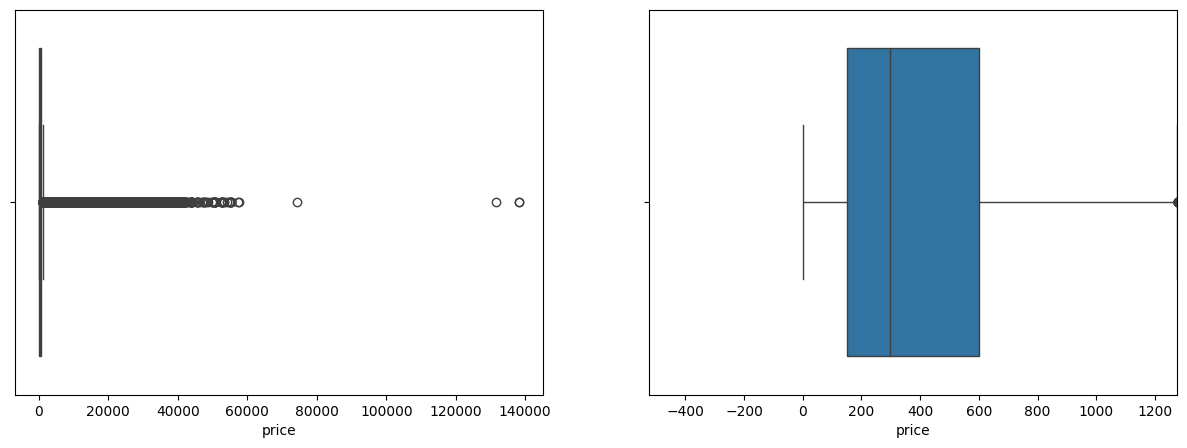

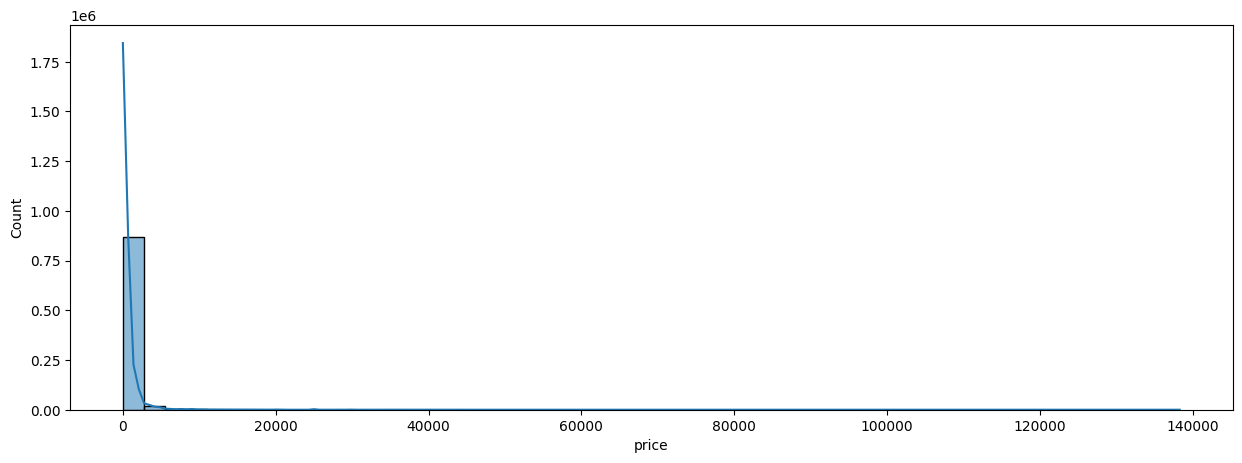

In [ ]:
diagrama_caixa(base_airbnb["price"])
histograma(base_airbnb["price"])

Como estamos construindo um modelo para imóveis comuns, acredito que os valores acima do limite superior serão apenas de apartamentos de altíssimo luxo, que não é o nosso objetivo principal. Por isso, podemos excluir esses outliers.

In [ ]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, "price")
print(f"Linhas removidas: {linhas_removidas}")

Linhas removidas: 87282


(810427, 23)


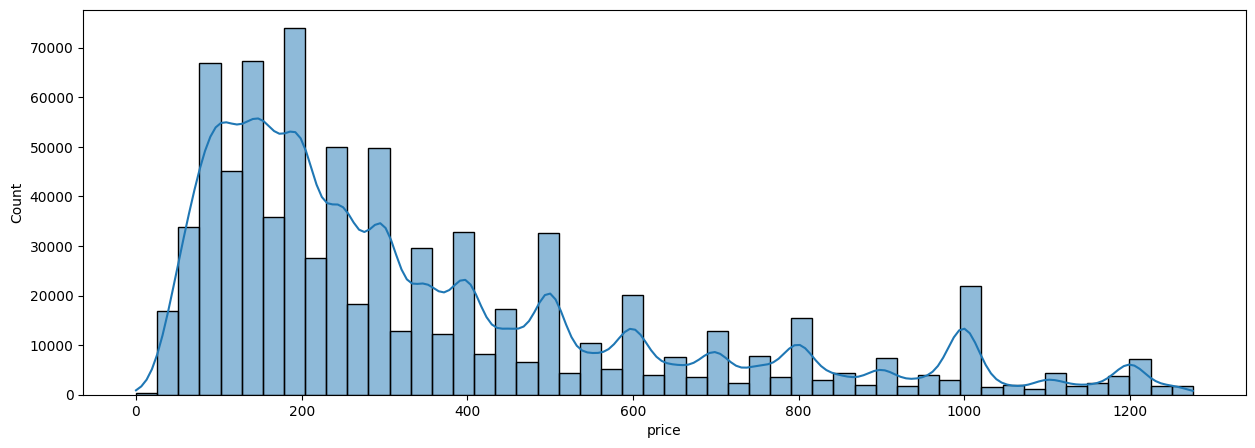

In [ ]:
histograma(base_airbnb["price"])
print(base_airbnb.shape)

### extra_people

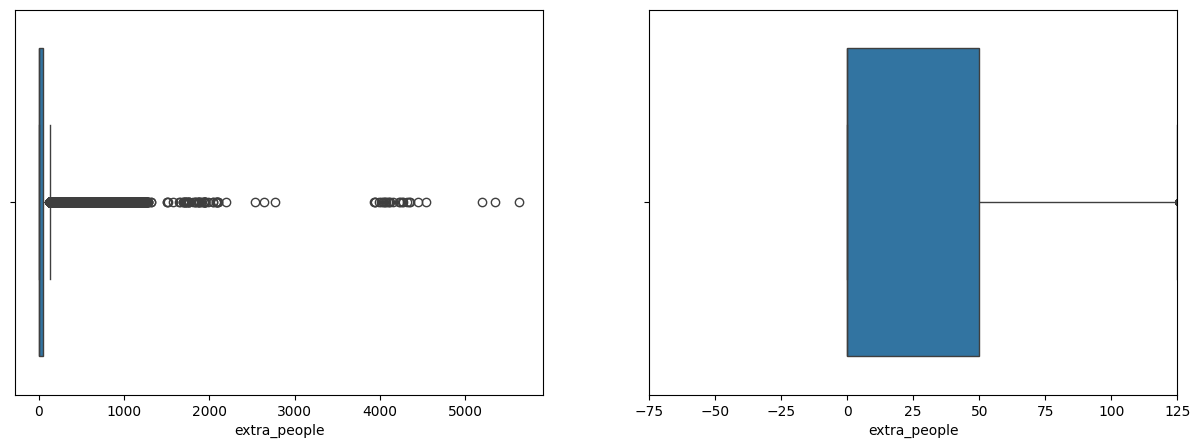

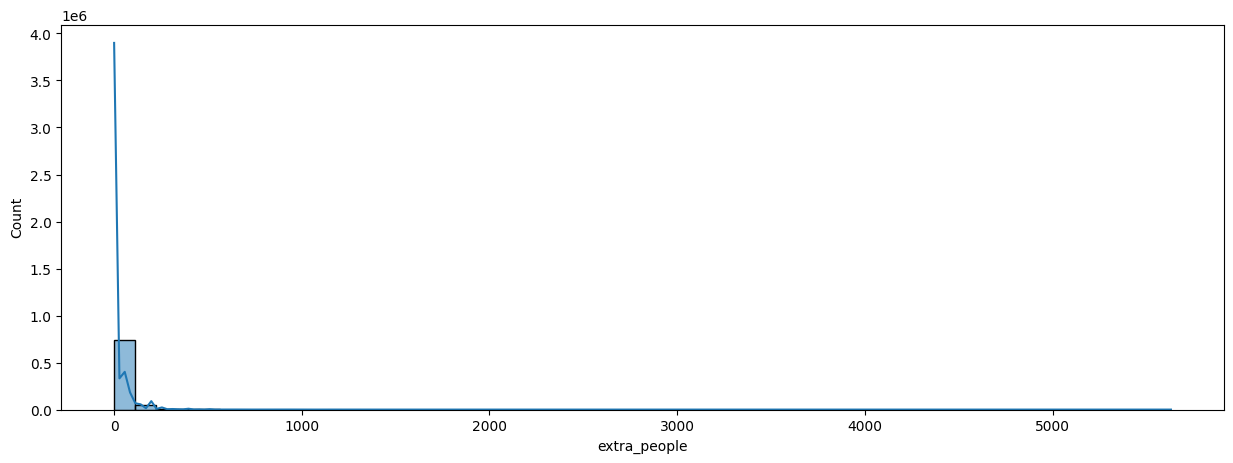

In [15]:
diagrama_caixa(base_airbnb["extra_people"])
histograma(base_airbnb["extra_people"])

In [16]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, "extra_people")
print(f"Linhas removidas: {linhas_removidas}")

Linhas removidas: 59194


(751233, 23)


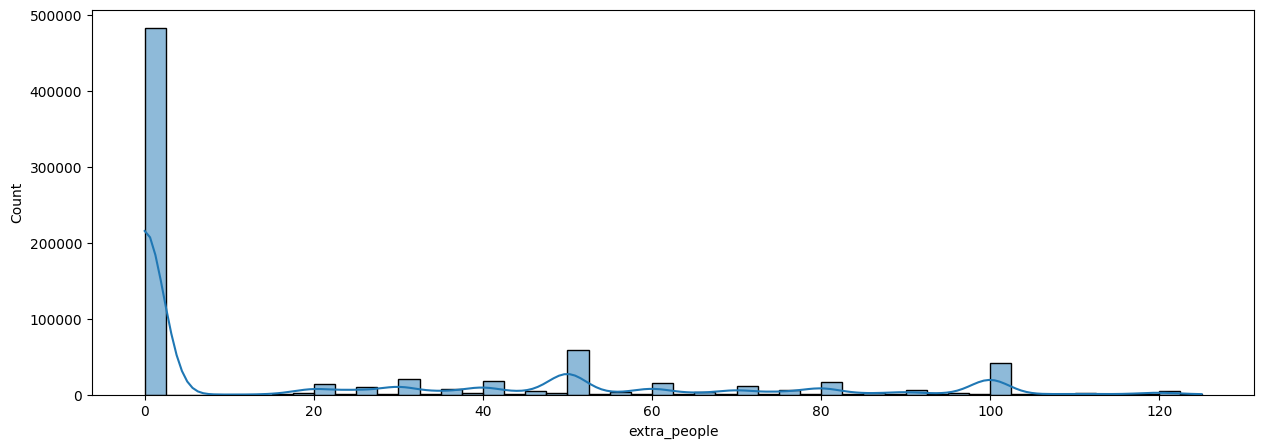

In [17]:
histograma(base_airbnb["extra_people"])
print(base_airbnb.shape)

### host_listings_count

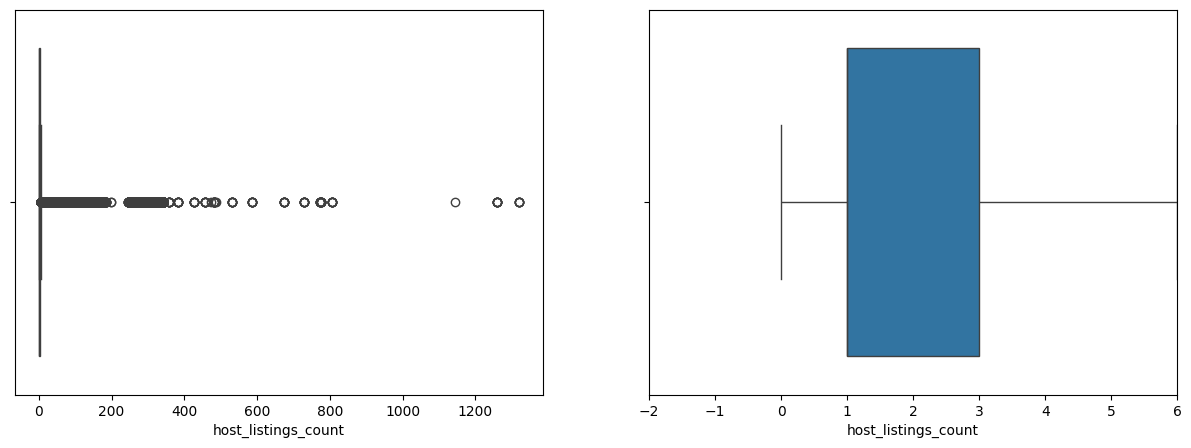

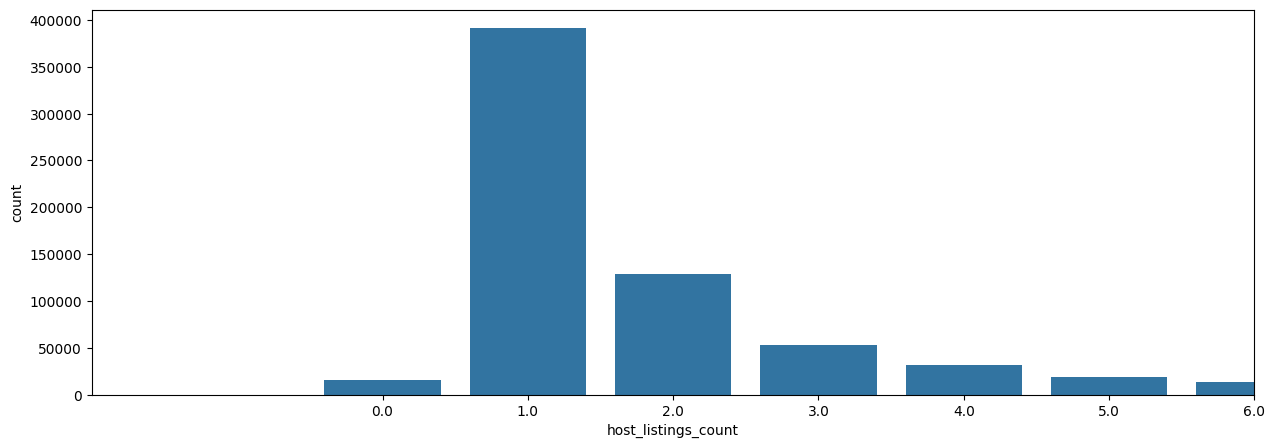

In [18]:
diagrama_caixa(base_airbnb["host_listings_count"])
grafico_barra(base_airbnb["host_listings_count"])

Podemos excluir os outliers, porque para o objetivo do nosso projeto hosts com mais de 6 imóveis no airbnb não é o público alvo do objetivo do projeto (imagino que sejam imobiliários ou profissionais que gerenciam imóveis no airbnb)

In [19]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, "host_listings_count")
print(f"Linhas removidas: {linhas_removidas}")

Linhas removidas: 97723


### acommodates

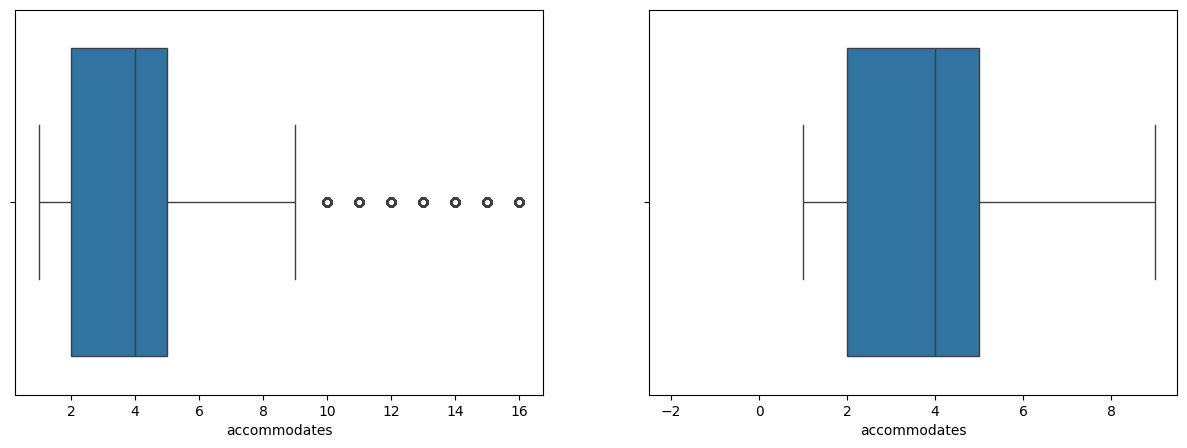

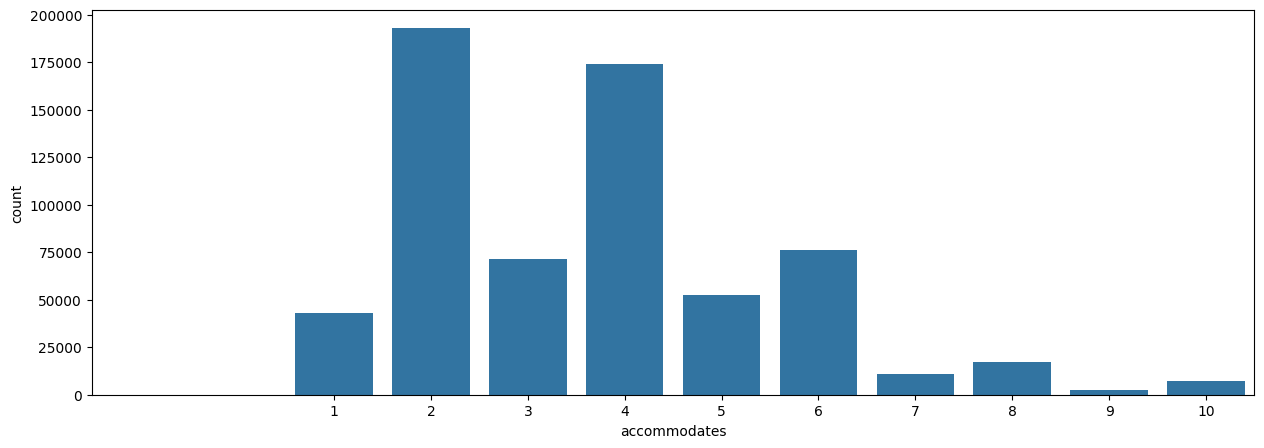

In [20]:
diagrama_caixa(base_airbnb["accommodates"])
grafico_barra(base_airbnb["accommodates"])

In [21]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, "accommodates")
print(f"Linhas removidas: {linhas_removidas}")

Linhas removidas: 13146


### bathrooms

<Axes: xlabel='bathrooms', ylabel='count'>

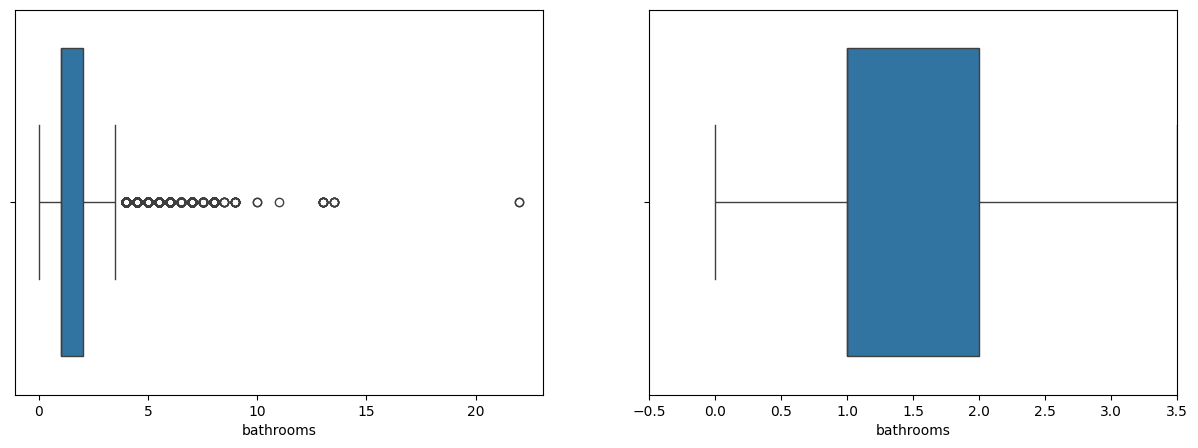

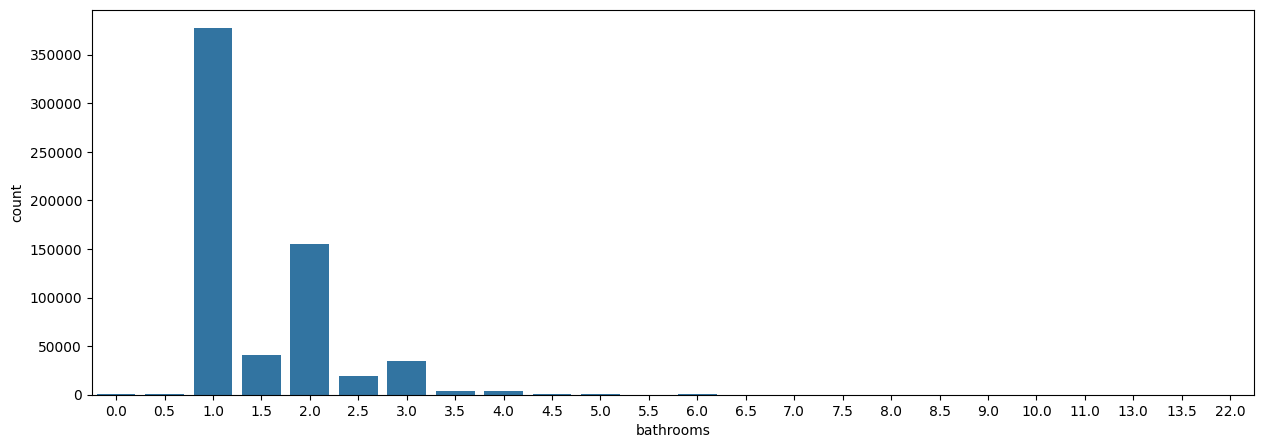

In [22]:
diagrama_caixa(base_airbnb["bathrooms"])
plt.figure(figsize=(15, 5))
sns.barplot(
    x=base_airbnb["bathrooms"].value_counts().index,
    y=base_airbnb["bathrooms"].value_counts(),
)

In [23]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, "bathrooms")
print(f"Linhas removidas: {linhas_removidas}")

Linhas removidas: 6894


### bedrooms

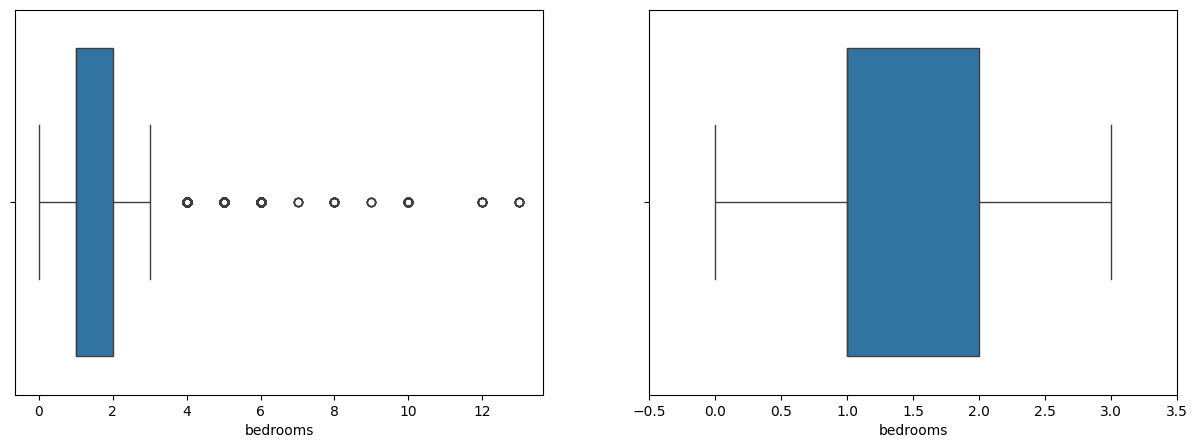

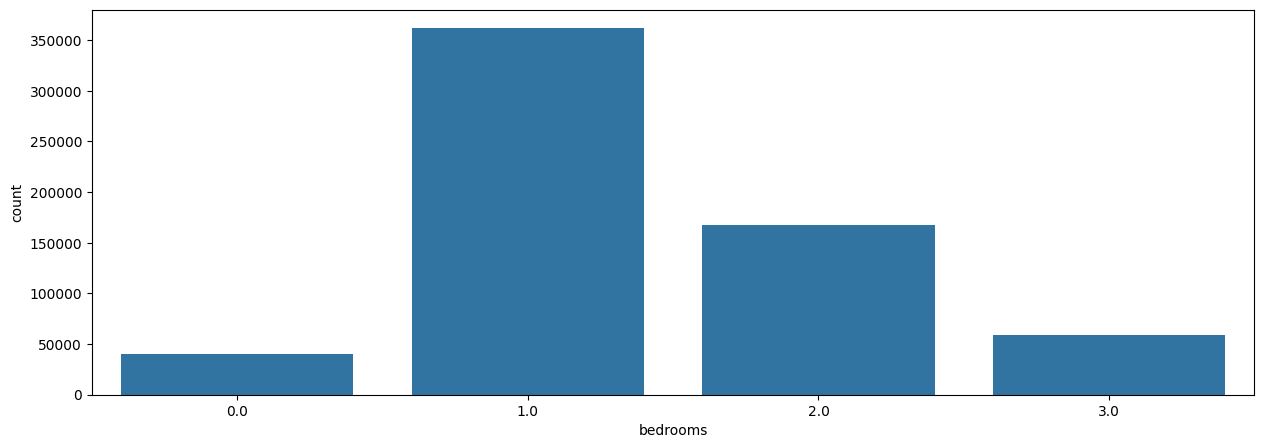

In [24]:
diagrama_caixa(base_airbnb["bedrooms"])
grafico_barra(base_airbnb["bedrooms"])

In [25]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, "bedrooms")
print(f"Linhas removidas: {linhas_removidas}")

Linhas removidas: 5482


### beds

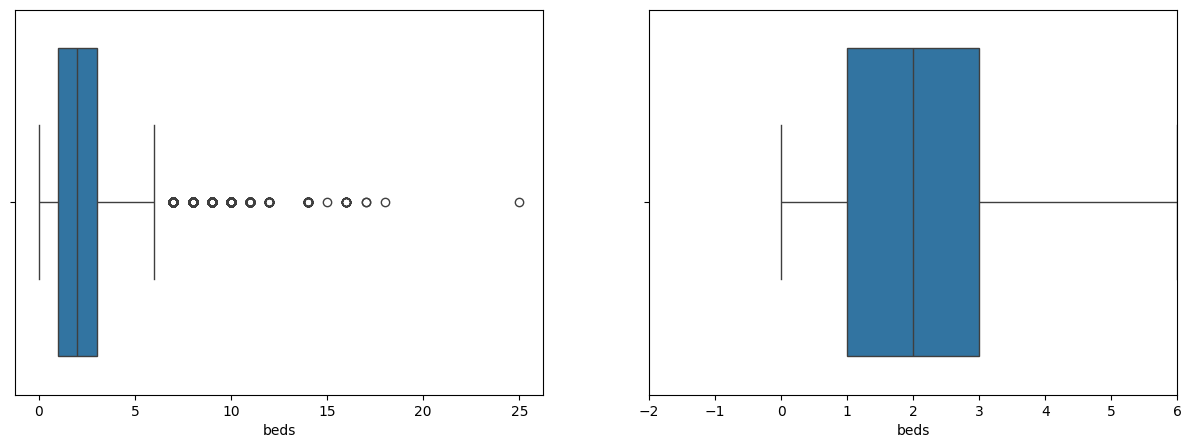

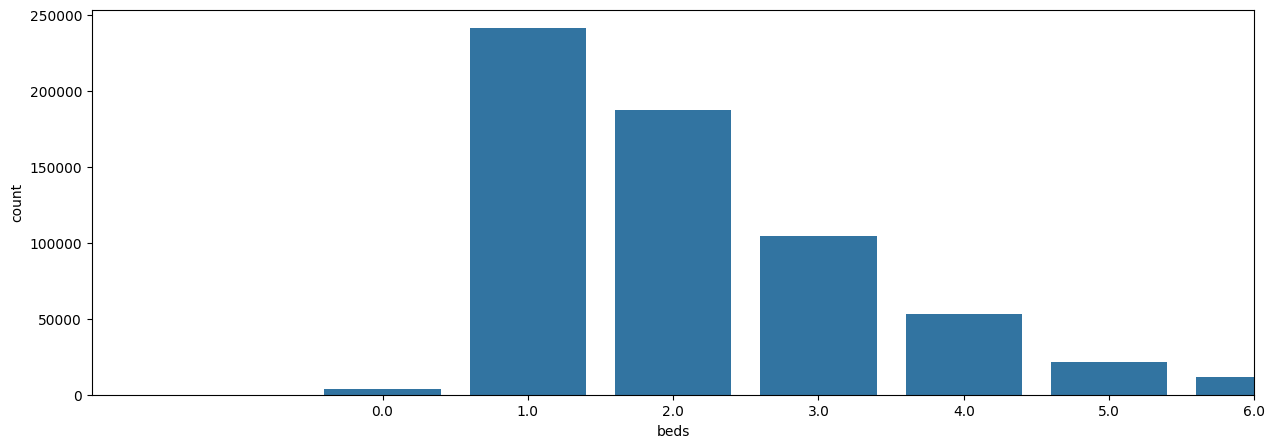

In [26]:
diagrama_caixa(base_airbnb["beds"])
grafico_barra(base_airbnb["beds"])

In [27]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, "beds")
print(f"Linhas removidas: {linhas_removidas}")

Linhas removidas: 5622


### guests_included

(np.float64(1.0), np.float64(1.0))


<Axes: xlabel='guests_included', ylabel='count'>

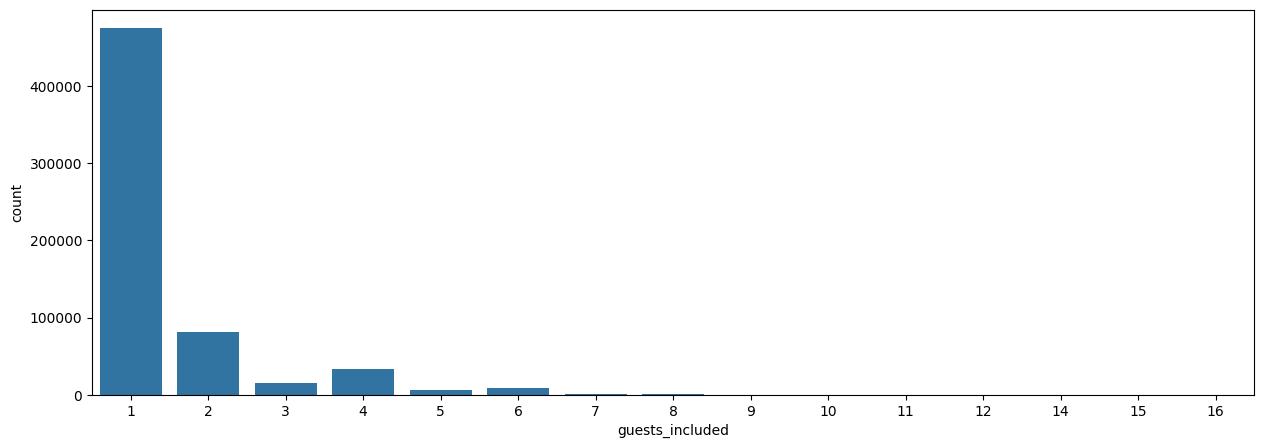

In [ ]:
print(limites(base_airbnb["guests_included"]))
plt.figure(figsize=(15, 5))
sns.barplot(
    x=base_airbnb["guests_included"].value_counts().index,
    y=base_airbnb["guests_included"].value_counts(),
)

Vamos remover essa feature da análise. Parece que os usuários do airbnb usam muito o valor padrão do airbnb como 1 guest included. Isso pode levar o nosso modelo a considerar uma feature que na verdade não é essencial para a definição do preço, por isso, me parece melhor excluir a coluna da análise

In [29]:
base_airbnb = base_airbnb.drop("guests_included", axis=1)
base_airbnb.shape

(622366, 22)

### minimum_nights

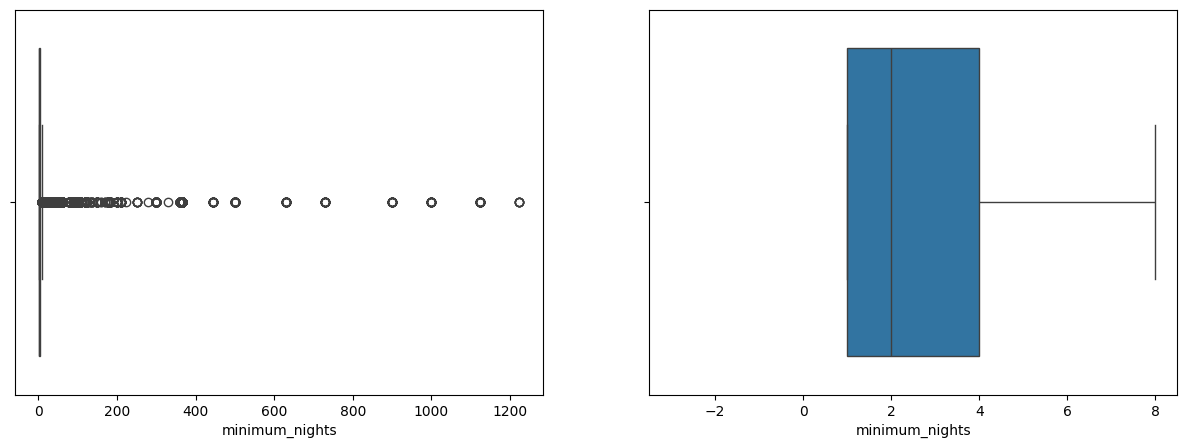

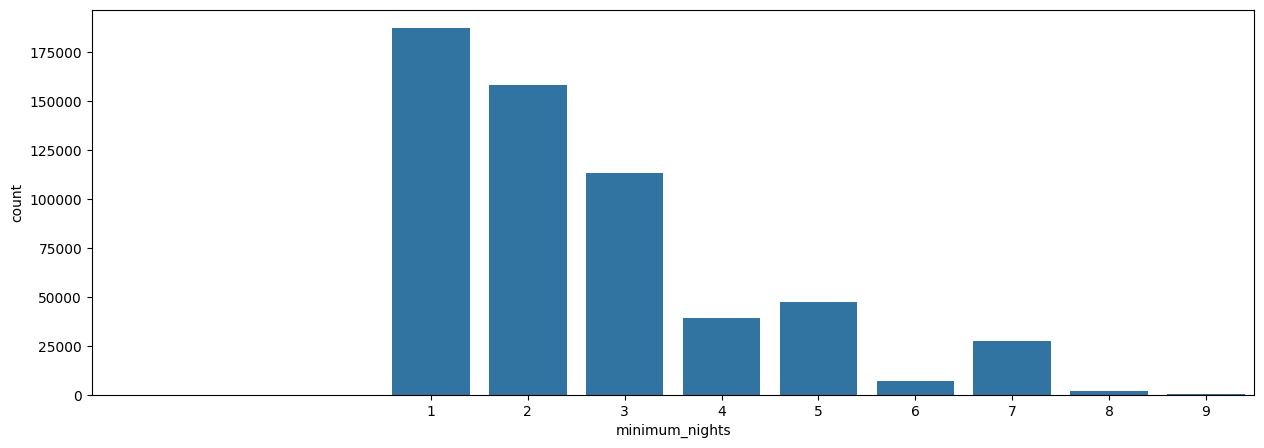

In [30]:
diagrama_caixa(base_airbnb["minimum_nights"])
grafico_barra(base_airbnb["minimum_nights"])

- Aqui temos um motivo talvez até mais forte para excluir esses apartamentos da análise.

- Estamos querendo um modelo que ajude a precificar apartamentos comuns como uma pessoa comum gostaria de disponibilizar. No caso, apartamentos com mais de 8 noites como o "mínimo de noites" podem ser apartamentos de temporada ou ainda apartamentos para morar, em que o host exige pelo menos 1 mês no apartamento.

- Por isso, vamos excluir os outliers dessa coluna

In [31]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, "minimum_nights")
print(f"Linhas removidas: {linhas_removidas}")

Linhas removidas: 40383


### maximum_nights

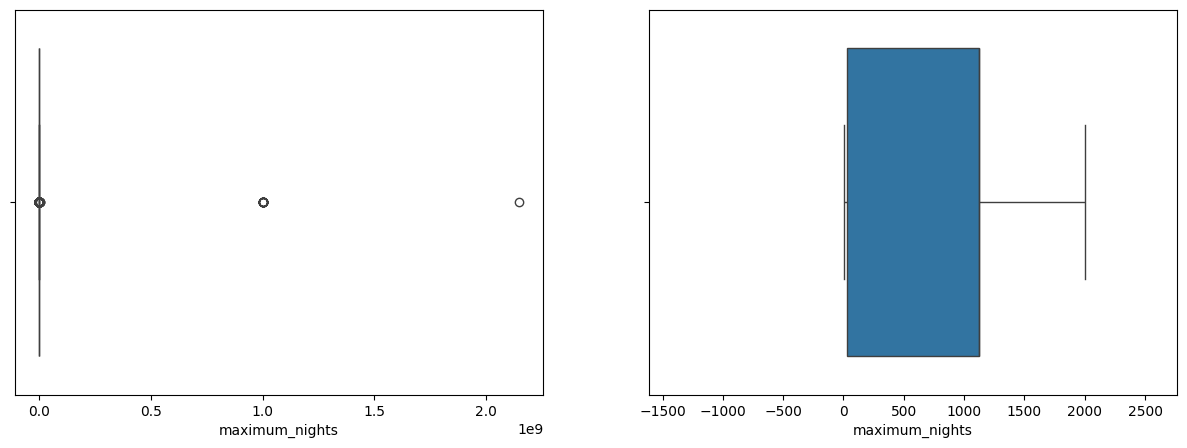

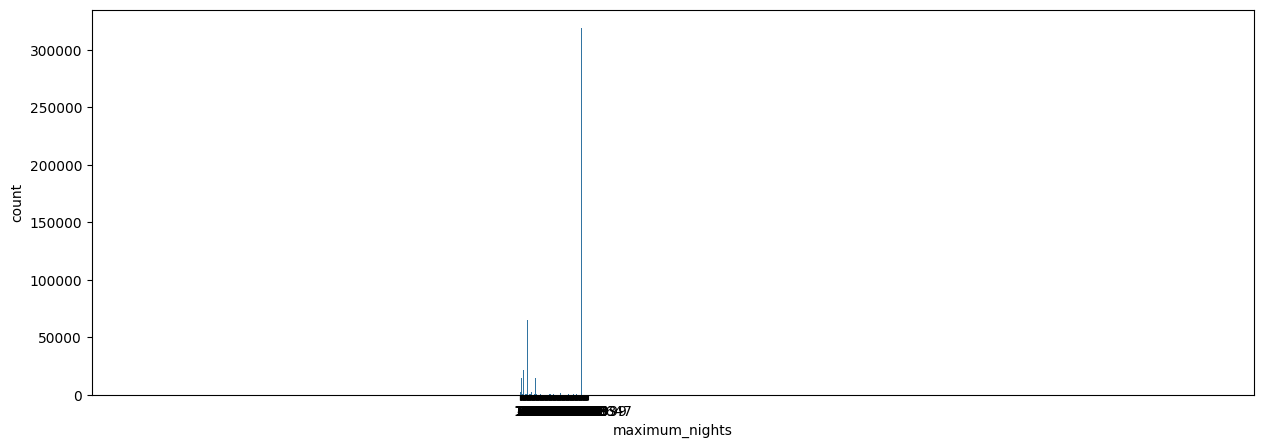

In [32]:
diagrama_caixa(base_airbnb["maximum_nights"])
grafico_barra(base_airbnb["maximum_nights"])

- Essa coluna não parece que vai ajudar na análise.

- Isso porque parece que quase todos os hosts não preenchem esse campo de maximum nights, então ele não parece que vai ser um fator relevante.

- É melhor excluirmos essa coluna da análise

In [33]:
base_airbnb = base_airbnb.drop("maximum_nights", axis=1)
base_airbnb.shape

(581983, 21)

### number_of_reviews

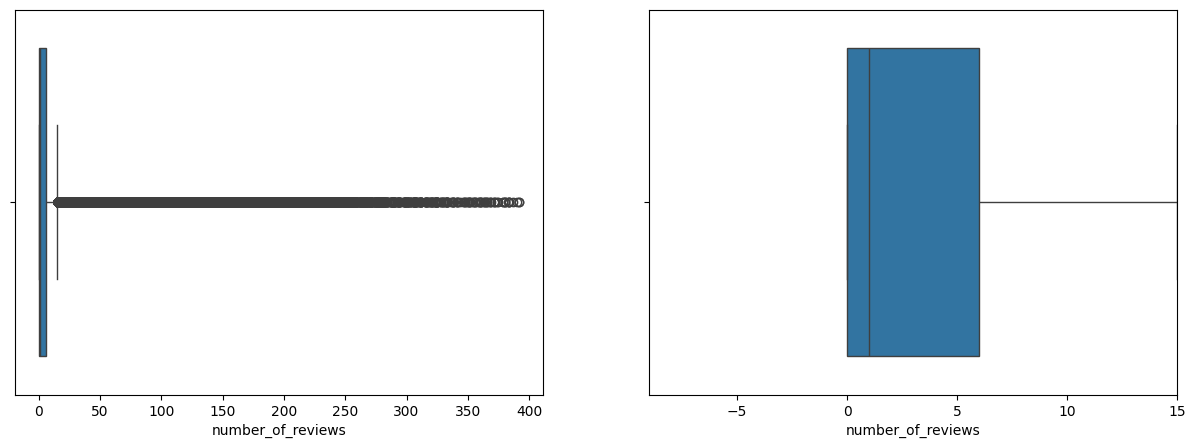

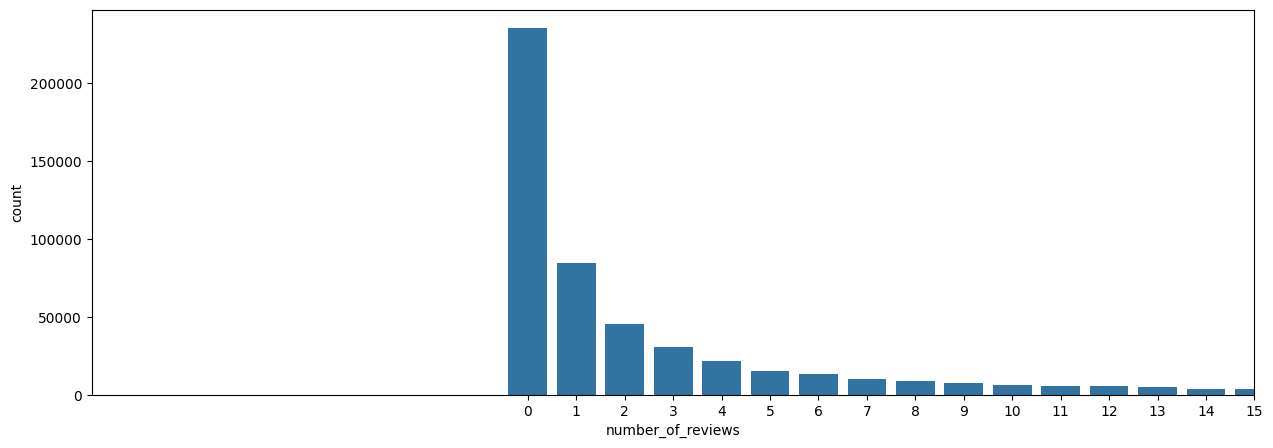

In [34]:
diagrama_caixa(base_airbnb["number_of_reviews"])
grafico_barra(base_airbnb["number_of_reviews"])

- Aqui poderíamos tomar algumas decisões diferentes. Eu vou tomar uma decisão baseado na minha análise pessoal de tirar essa característica da análise, por alguns motivos:

    1. Se excluirmos os outliers, vamos excluir as pessoas que tem a maior quantidade de reviews (o que normalmente são os hosts que têm mais aluguel). Isso pode impactar muito negativamente o nosso modelo
    2. Pensando no nosso objetivo, se eu tenho um imóvel parado e quero colocar meu imóvel lá, é claro que eu não tenho review nenhuma. Então talvez tirar essa característica da análise pode na verdade acabar ajudando.
    3. Particularmente tenho dúvida se essa característica deveria impactar ou não o preço final

In [35]:
base_airbnb = base_airbnb.drop("number_of_reviews", axis=1)
base_airbnb.shape

(581983, 20)

### Tratamento de Colunas de Valores de Texto

### property_type

property_type
Apartment                 458354
House                      51387
Condominium                26456
Serviced apartment         12671
Loft                       12352
Guest suite                 3621
Bed and breakfast           3472
Hostel                      2665
Guesthouse                  2155
Other                       1957
Villa                       1294
Townhouse                    969
Aparthotel                   693
Chalet                       481
Earth house                  468
Tiny house                   457
Boutique hotel               447
Hotel                        376
Casa particular (Cuba)       298
Cottage                      230
Bungalow                     207
Dorm                         185
Cabin                        141
Nature lodge                 124
Castle                        80
Treehouse                     76
Island                        54
Boat                          53
Hut                           40
Campsite                     

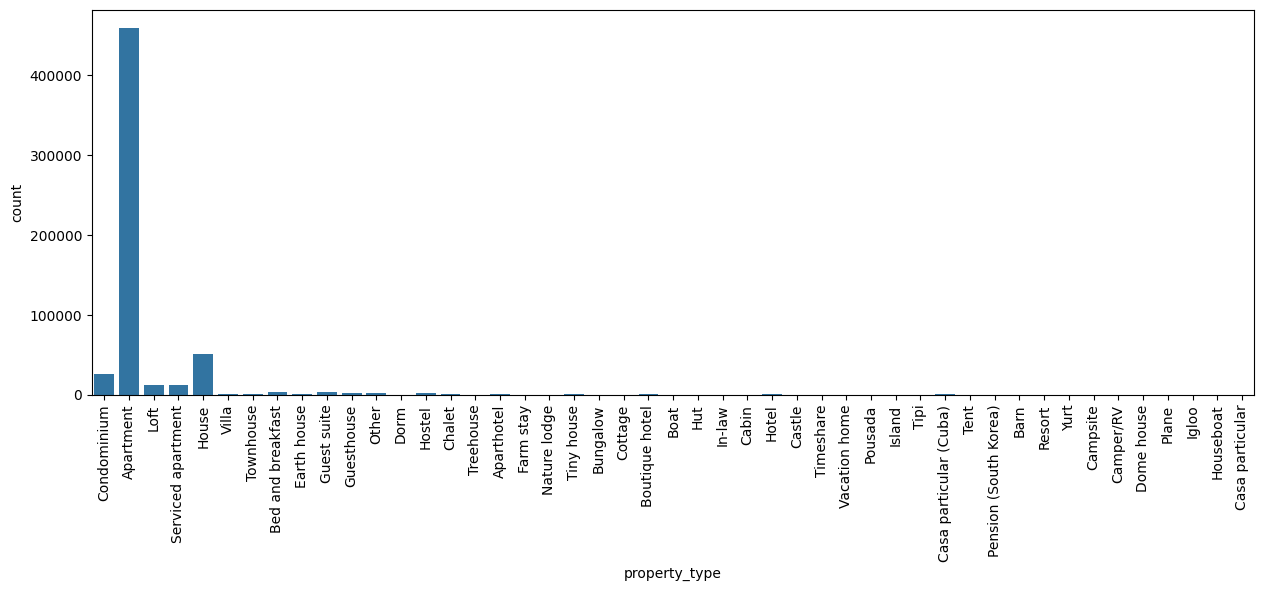

In [36]:
print(base_airbnb["property_type"].value_counts())

plt.figure(figsize=(15, 5))
grafico = sns.countplot(x="property_type", data=base_airbnb)
grafico.tick_params(axis="x", rotation=90)

- Aqui a nossa ação não é "excluir outliers", mas sim agrupar valores que são muito pequenos.

- Todos os tipos de propriedade que têm menos de 2.000 propriedades na base de dados, eu vou agrupar em um grupo chamado "outros". Acho que isso vai facilitar o nosso modelo

['Other', 'Villa', 'Townhouse', 'Aparthotel', 'Chalet', 'Earth house', 'Tiny house', 'Boutique hotel', 'Hotel', 'Casa particular (Cuba)', 'Cottage', 'Bungalow', 'Dorm', 'Cabin', 'Nature lodge', 'Castle', 'Treehouse', 'Island', 'Boat', 'Hut', 'Campsite', 'Resort', 'Camper/RV', 'Yurt', 'Tent', 'Tipi', 'Barn', 'Farm stay', 'Pension (South Korea)', 'Dome house', 'In-law', 'Igloo', 'Vacation home', 'Timeshare', 'Pousada', 'Houseboat', 'Casa particular', 'Plane']
property_type
Apartment             458354
House                  51387
Condominium            26456
Serviced apartment     12671
Loft                   12352
Outros                  8850
Guest suite             3621
Bed and breakfast       3472
Hostel                  2665
Guesthouse              2155
Name: count, dtype: int64


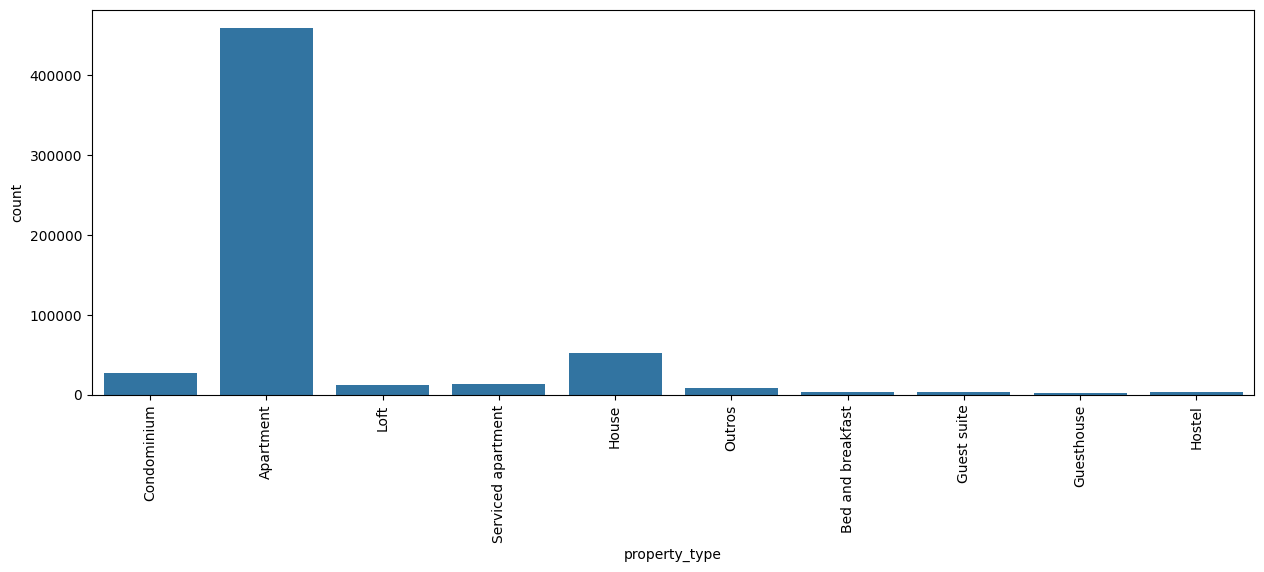

In [37]:
tabela_tipos_casa = base_airbnb["property_type"].value_counts()
colunas_agrupar = []

for tipo in tabela_tipos_casa.index:
    if tabela_tipos_casa[tipo] < 2000:
        colunas_agrupar.append(tipo)
print(colunas_agrupar)

for tipo in colunas_agrupar:
    base_airbnb.loc[base_airbnb["property_type"] == tipo, "property_type"] = "Outros"

print(base_airbnb["property_type"].value_counts())
plt.figure(figsize=(15, 5))
grafico = sns.countplot(x="property_type", data=base_airbnb)
grafico.tick_params(axis="x", rotation=90)

### room_type

room_type
Entire home/apt    372443
Private room       196859
Shared room         11714
Hotel room            967
Name: count, dtype: int64


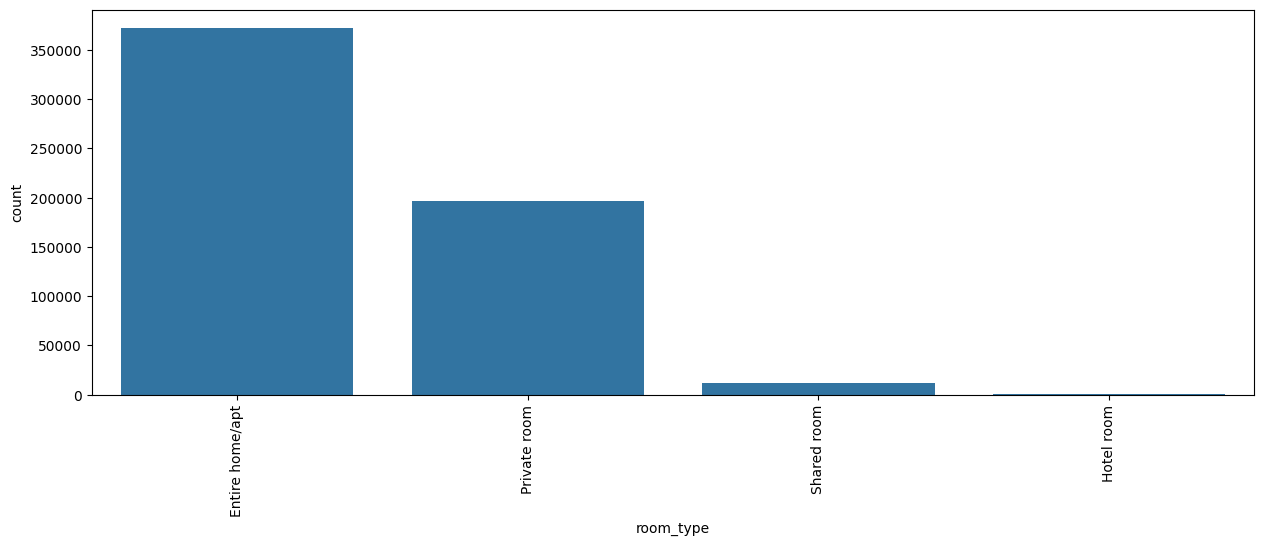

In [38]:
print(base_airbnb["room_type"].value_counts())

plt.figure(figsize=(15, 5))
grafico = sns.countplot(x="room_type", data=base_airbnb)
grafico.tick_params(axis="x", rotation=90)

### bed_type

bed_type
Real Bed         570643
Pull-out Sofa      8055
Futon              1634
Airbed             1155
Couch               496
Name: count, dtype: int64


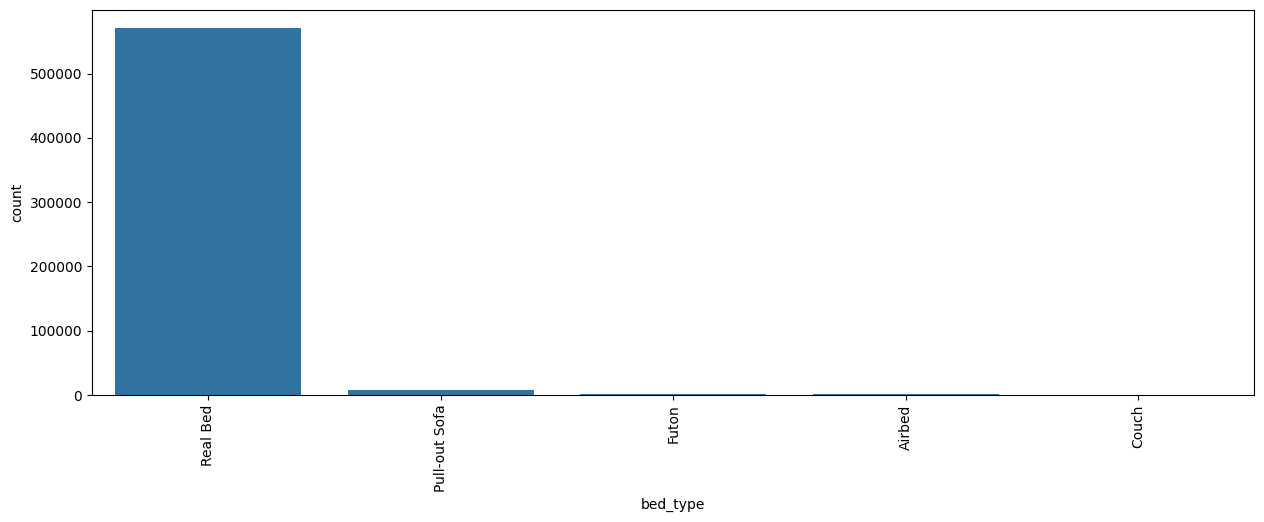

In [39]:
print(base_airbnb["bed_type"].value_counts())

plt.figure(figsize=(15, 5))
grafico = sns.countplot(x="bed_type", data=base_airbnb)
grafico.tick_params(axis="x", rotation=90)

- Aqui a nossa ação não é "excluir outliers", mas sim agrupar valores que são muito pequenos.

- Como temos 1 valor claramente MUITO maior do que todos os outros, vou criar apenas 2 grupos de camas: "Real Bed" e "outros"

Isso vai simplificar o modelo

['Pull-out Sofa', 'Futon', 'Airbed', 'Couch']
bed_type
Real Bed    570643
Outros       11340
Name: count, dtype: int64


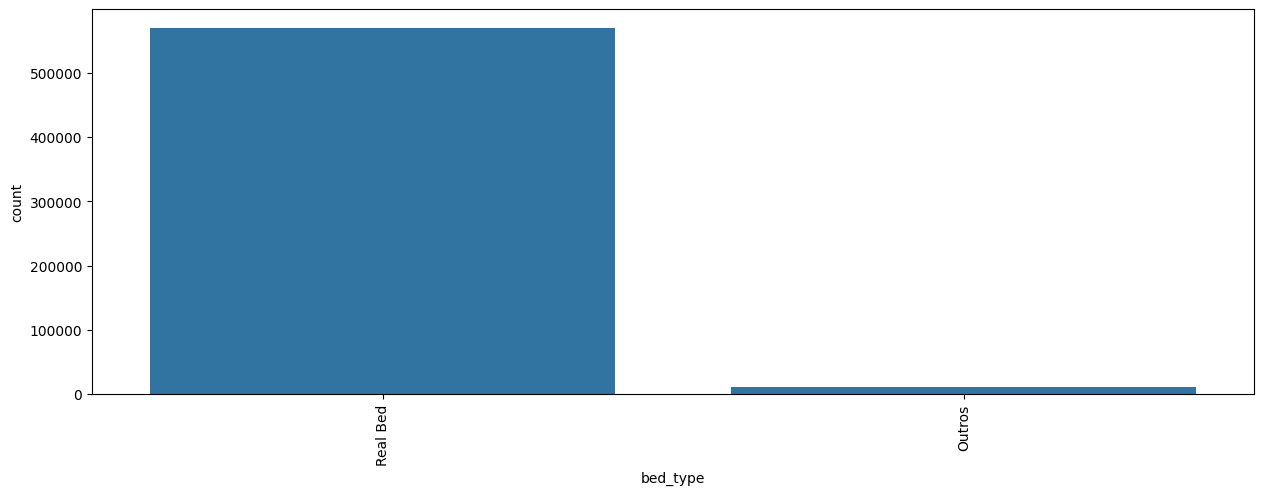

In [40]:
tabela_bed = base_airbnb["bed_type"].value_counts()
colunas_agrupar = []

for tipo in tabela_bed.index:
    if tabela_bed[tipo] < 10000:
        colunas_agrupar.append(tipo)
print(colunas_agrupar)

for tipo in colunas_agrupar:
    base_airbnb.loc[base_airbnb["bed_type"] == tipo, "bed_type"] = "Outros"

print(base_airbnb["bed_type"].value_counts())
plt.figure(figsize=(15, 5))
grafico = sns.countplot(x="bed_type", data=base_airbnb)
grafico.tick_params(axis="x", rotation=90)

### cancellation_policy

cancellation_policy
flexible                       258096
strict_14_with_grace_period    200743
moderate                       113281
strict                           9696
super_strict_60                   135
super_strict_30                    32
Name: count, dtype: int64


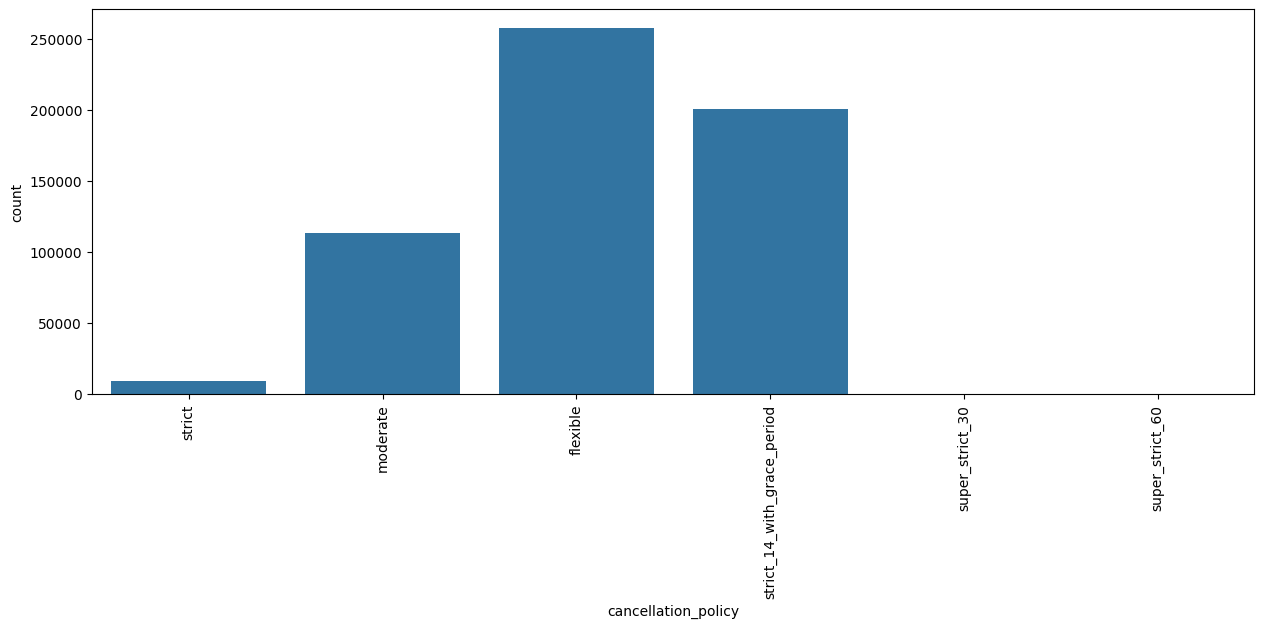

In [41]:
print(base_airbnb["cancellation_policy"].value_counts())

plt.figure(figsize=(15, 5))
grafico = sns.countplot(x="cancellation_policy", data=base_airbnb)
grafico.tick_params(axis="x", rotation=90)

['strict', 'super_strict_60', 'super_strict_30']
cancellation_policy
flexible                       258096
strict_14_with_grace_period    200743
moderate                       113281
strict                           9863
Name: count, dtype: int64


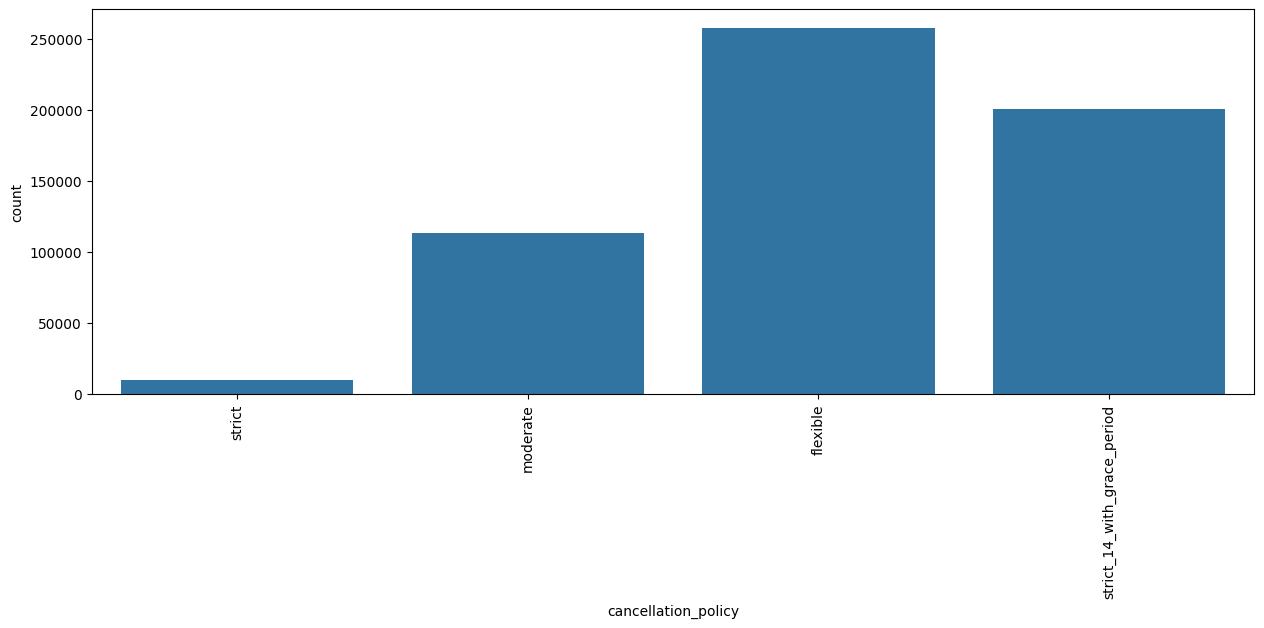

In [42]:
tabela_cancellation = base_airbnb["cancellation_policy"].value_counts()
colunas_agrupar = []

for tipo in tabela_cancellation.index:
    if tabela_cancellation[tipo] < 10000:
        colunas_agrupar.append(tipo)
print(colunas_agrupar)

for tipo in colunas_agrupar:
    base_airbnb.loc[
        base_airbnb["cancellation_policy"] == tipo, "cancellation_policy"
    ] = "strict"

print(base_airbnb["cancellation_policy"].value_counts())
plt.figure(figsize=(15, 5))
grafico = sns.countplot(x="cancellation_policy", data=base_airbnb)
grafico.tick_params(axis="x", rotation=90)

### amenities

Como temos uma diversidade muito grande de amenities e, às vezes, as mesmas amenities podem ser escritas de forma diferente, vamos avaliar a quantidade de amenities como o parâmetro para o nosso modelo.

In [43]:
print(base_airbnb["amenities"].iloc[1].split(","))
print(len(base_airbnb["amenities"].iloc[1].split(",")))

base_airbnb["n_amenities"] = base_airbnb["amenities"].str.split(",").apply(len)

['{TV', '"Cable TV"', 'Internet', 'Wifi', '"Air conditioning"', 'Kitchen', 'Doorman', 'Elevator', '"Buzzer/wireless intercom"', '"Family/kid friendly"', 'Hangers', '"Hair dryer"', 'Iron', '"Laptop friendly workspace"}']
14


In [44]:
base_airbnb = base_airbnb.drop("amenities", axis=1)
base_airbnb.shape

(581983, 20)

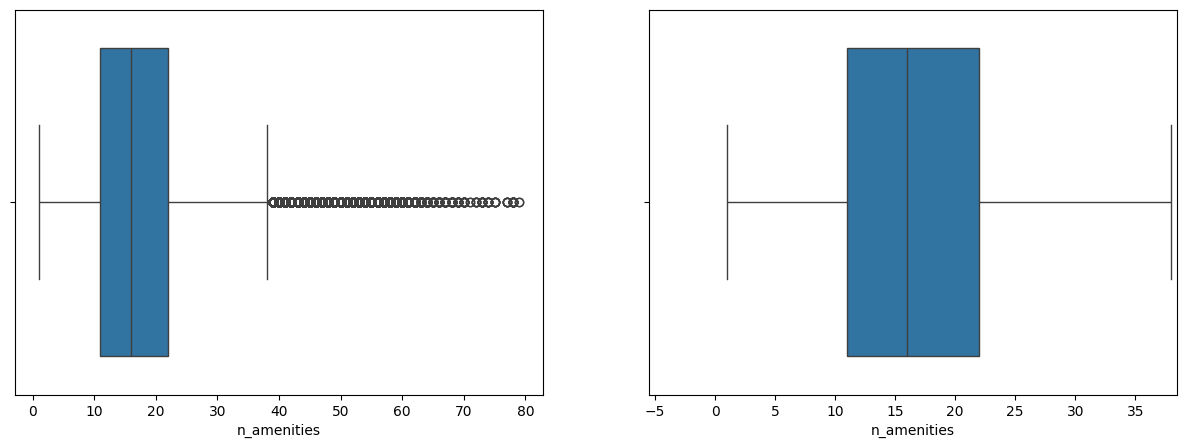

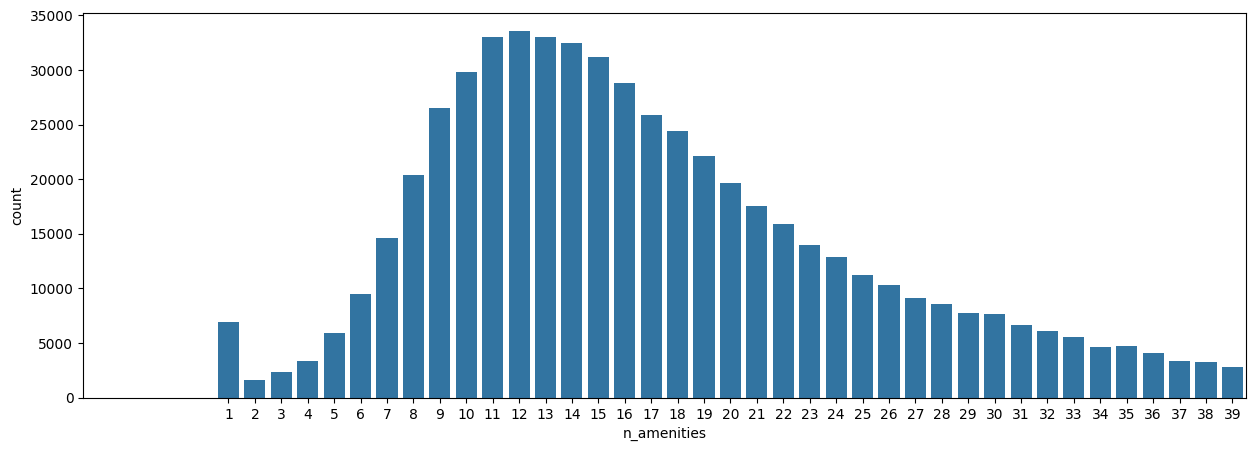

In [45]:
diagrama_caixa(base_airbnb["n_amenities"])
grafico_barra(base_airbnb["n_amenities"])

Então, essa virou uma coluna de valor numérico e, como todas as outras colunas de valores numéricos, eu exclui outliers com os mesmos modelos anteriores

In [46]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, "n_amenities")
print("{} linhas removidas".format(linhas_removidas))

24343 linhas removidas


### Visualização de Mapa das Propriedades

Vamos criar um mapa que exibe um pedaço da nossa base de dados aleatório (50.000 propriedades) para ver como as propriedades estão distribuídas pela cidade e também identificar os locais de maior preço 

In [47]:
amostra = base_airbnb.sample(n=50000)
centro_mapa = {"lat": amostra.latitude.mean(), "lon": amostra.longitude.mean()}
mapa = px.density_map(
    amostra,
    lat="latitude",
    lon="longitude",
    z="price",
    radius=2.5,
    center=centro_mapa,
    zoom=10,
    map_style="open-street-map",
)
mapa.show()

### Encoding

Precisamos ajustar as features para facilitar o trabalho do modelo futuro (features de categoria, true e false, etc.)

- Features de Valores True ou False, vamos substituir True por 1 e False por 0.
- Features de Categoria (features em que os valores da coluna são textos) vamos utilizar o método de encoding de variáveis dummies

In [48]:
colunas_tf = ["host_is_superhost", "instant_bookable", "is_business_travel_ready"]
base_airbnb_cod = base_airbnb.copy()
for coluna in colunas_tf:
    base_airbnb_cod.loc[base_airbnb_cod[coluna] == "t", coluna] = 1
    base_airbnb_cod.loc[base_airbnb_cod[coluna] == "f", coluna] = 0

In [49]:
colunas_categorias = ["property_type", "room_type", "bed_type", "cancellation_policy"]
base_airbnb_cod = pd.get_dummies(data=base_airbnb_cod, columns=colunas_categorias)
display(base_airbnb_cod.head())

,host_is_superhost,host_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,extra_people,...,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,bed_type_Outros,bed_type_Real Bed,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_strict_14_with_grace_period
1,1,2.0,-22.965919,-43.178962,5,1.0,2.0,2.0,270.0,51.0,...,True,False,False,False,False,True,False,False,True,False
3,0,3.0,-22.977117,-43.190454,3,1.0,1.0,2.0,161.0,45.0,...,True,False,False,False,False,True,False,False,True,False
4,1,1.0,-22.983024,-43.214270,3,1.0,1.0,2.0,222.0,68.0,...,True,False,False,False,False,True,False,False,True,False
5,1,1.0,-22.988165,-43.193588,3,1.5,1.0,2.0,308.0,86.0,...,True,False,False,False,False,True,False,False,True,False
6,1,1.0,-22.981269,-43.190457,2,1.0,1.0,2.0,219.0,80.0,...,True,False,False,False,False,True,False,False,True,False


### Modelo de Previsão

- Métricas de Avaliação

Vamos usar aqui o R² que vai nos dizer o quão bem o nosso modelo consegue explicar o preço. Isso seria um ótimo parâmetro para ver o quão bom é nosso modelo <br>
-> Quanto mais próximo de 100%, melhor

Vou calcular também o Erro Quadrático Médio, que vai mostrar para gente o quanto o nosso modelo está errando. <br>
-> Quanto menor for o erro, melhor

In [52]:
def avaliar_modelo(nome_modelo, y_teste, previsao):
    r2 = r2_score(y_teste, previsao)
    RSME = np.sqrt(mean_squared_error(y_teste, previsao))
    return f"Modelo {nome_modelo}:\nR²:{r2:.2%}\nRSME:{RSME:.2f}"

- Escolha dos Modelos a Serem Testados
    1. RandomForest
    2. LinearRegression
    3. Extra Tree

In [53]:
modelo_rf = RandomForestRegressor()
modelo_lr = LinearRegression()
modelo_et = ExtraTreesRegressor()

modelos = {
    "RandomForest": modelo_rf,
    "LinearRegression": modelo_lr,
    "ExtraTrees": modelo_et,
}

y = base_airbnb_cod["price"]
X = base_airbnb_cod.drop("price", axis=1)

- Separa os dados em treino e teste + Treino do Modelo

Essa etapa é crucial. As Inteligências Artificiais aprendendo com o que chamamos de treino.

Basicamente o que a gente faz é: a gente separa as informações em treino e teste, ex: 10% da base de dados vai servir para teste e 90% para treino (normalmente treino é maior mesmo)

Aí, damos para o modelo os dados de treino, ele vai olhar aqueles dados e aprender a prever os preços.

Depois que ele aprende, você faz um teste com ele, com os dados de teste, para ver se ela está bom ou não. Analisando os dados de teste você descobre o melhor modelo

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

for nome_modelo, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    previsao = modelo.predict(X_test)
    print(avaliar_modelo(nome_modelo, y_test, previsao))

Modelo RandomForest:
R²:97.25%
RSME:43.99
Modelo LinearRegression:
R²:32.70%
RSME:217.54
Modelo ExtraTrees:
R²:97.51%
RSME:41.83


### Análise do Melhor Modelo

In [ ]:
for nome_modelo, modelo in modelos.items():
    previsao = modelo.predict(X_test)
    print(avaliar_modelo(nome_modelo, y_test, previsao))

Modelo RandomForest:
R²:97.25%
RSME:43.99
Modelo LinearRegression:
R²:32.70%
RSME:217.54
Modelo ExtraTrees:
R²:97.51%
RSME:41.83


- Modelo Escolhido como Melhor Modelo: ExtraTressRegressor

    Esse foi o modelo com maior valor de R² e ao mesmo tempo o menor valor de RSME. Como não tivemos uma grande diferença de velocidade de treino e de previsão desse modelo com o modelo de RandomForest (que teve resultados próximos de R² e RSME), vamos escolher o Modelo ExtraTrees.
    
    O modelo de regressão linear não obteve um resultado satisfatório, com valores de R² e RSME muito piores do que os outros 2 modelos.
    
- Resultados das Métricas de Avaliaçõ no Modelo Vencedor:<br>
Modelo ExtraTrees:<br>
R²:97.51%<br>
RSME:41.83

### Ajustes e Melhorias no Melhor Modelo

,0
bedrooms,0.108390
latitude,0.104045
longitude,0.101453
n_amenities,0.088710
extra_people,0.086618
bathrooms,0.073960
accommodates,0.071266
room_type_Entire home/apt,0.069569
minimum_nights,0.065025
beds,0.052710


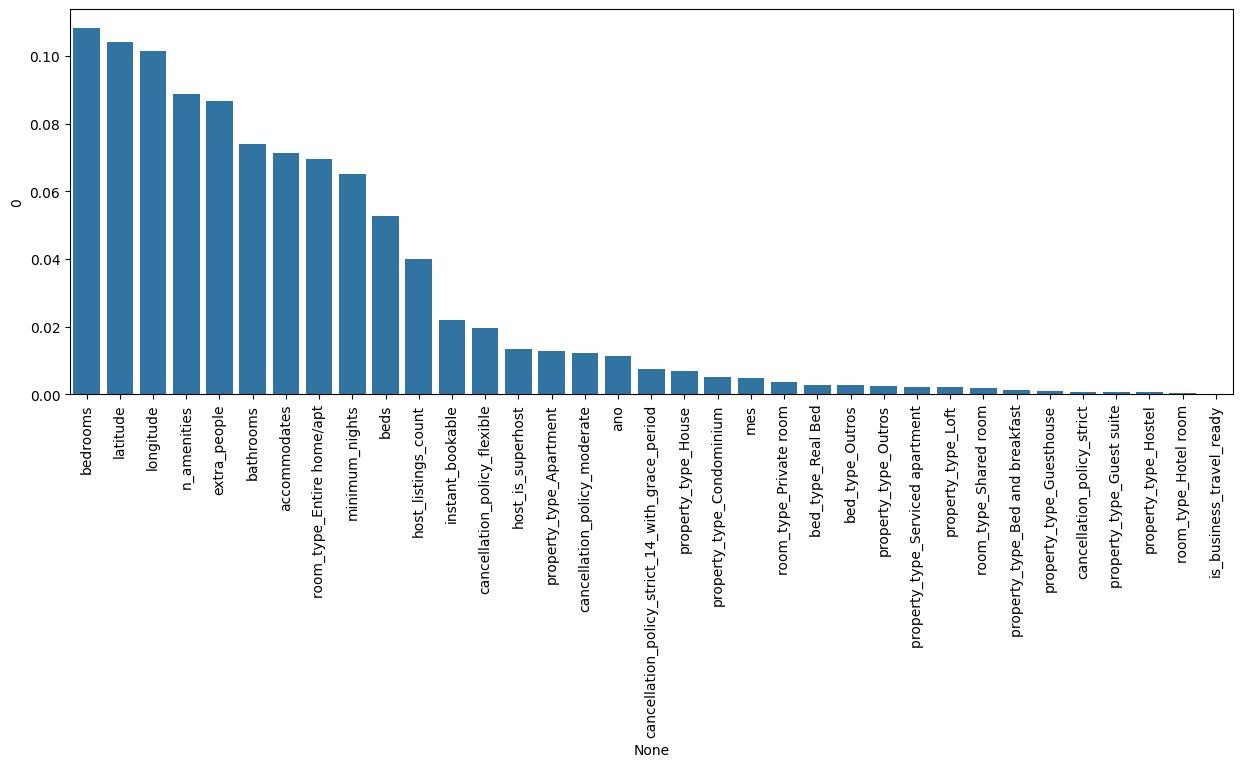

In [ ]:
importancia_features = pd.DataFrame(modelo_et.feature_importances_, X_train.columns)
importancia_features = importancia_features.sort_values(by=0, ascending=False)
display(importancia_features)
plt.figure(figsize=(15, 5))
ax = sns.barplot(x=importancia_features.index, y=importancia_features[0])
ax.tick_params(axis="x", rotation=90)

### Ajustes Finais no Modelo

- is_business_travel ready não parece ter muito impacto no nosso modelo. Por isso, para chegar em um modelo mais simples, vamos excluir essa feature e testar o modelo sem ela.

In [57]:
base_airbnb_cod = base_airbnb_cod.drop("is_business_travel_ready", axis=1)

y = base_airbnb_cod["price"]
X = base_airbnb_cod.drop("price", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

modelo_et.fit(X_train, y_train)
previsao = modelo_et.predict(X_test)
print(avaliar_modelo("ExtraTrees", y_test, previsao))

Modelo ExtraTrees:
R²:97.50%
RSME:41.89


In [58]:
base_teste = base_airbnb_cod.copy()
for coluna in base_teste:
    if "bed_type" in coluna:
        base_teste = base_teste.drop(coluna, axis=1)
print(base_teste.columns)
y = base_teste["price"]
X = base_teste.drop("price", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

modelo_et.fit(X_train, y_train)
previsao = modelo_et.predict(X_test)
print(avaliar_modelo("ExtraTrees", y_test, previsao))

Index(['host_is_superhost', 'host_listings_count', 'latitude', 'longitude',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price',
       'extra_people', 'minimum_nights', 'instant_bookable', 'ano', 'mes',
       'n_amenities', 'property_type_Apartment',
       'property_type_Bed and breakfast', 'property_type_Condominium',
       'property_type_Guest suite', 'property_type_Guesthouse',
       'property_type_Hostel', 'property_type_House', 'property_type_Loft',
       'property_type_Outros', 'property_type_Serviced apartment',
       'room_type_Entire home/apt', 'room_type_Hotel room',
       'room_type_Private room', 'room_type_Shared room',
       'cancellation_policy_flexible', 'cancellation_policy_moderate',
       'cancellation_policy_strict',
       'cancellation_policy_strict_14_with_grace_period'],
      dtype='object')
Modelo ExtraTrees:
R²:97.49%
RSME:41.98


In [59]:
print(previsao)

[100.98 998.53 249.16 ... 124.36 281.65 119.94]


# Deploy do Projeto

- Passo 1 -> Criar arquivo do Modelo (joblib)<br>
- Passo 2 -> Escolher a forma de deploy:
    - Arquivo Executável + Tkinter
    - Deploy em Microsite (Flask)
    - Deploy apenas para uso direto Streamlit
- Passo 3 -> Outro arquivo Python (pode ser Jupyter ou PyCharm)
- Passo 4 -> Importar streamlit e criar código
- Passo 5 -> Atribuir ao botão o carregamento do modelo
- Passo 6 -> Deploy feito

In [60]:
X["price"] = y
X.to_csv("dados.csv")

In [61]:
import joblib

joblib.dump(modelo_et, "modelo.joblib")

['modelo.joblib']